# DL Modeling - Pre Training - Noiser

Pre-training a model on all data (train+test) using the categorical features as classes.
We mask each categorical feature out (one at a time) and learn to predict its value.
We hope this will be a nice pre-training step in order to learn good initializations for the embeddings
    and even the fully-connected layers.
    
We are now adding more noise to input features.
We randomly mask some categorical features out additionally to the central feature.

In [13]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [14]:
import pandas as pd
import numpy as np
import os 

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from kdd_utils import addFieldDataFtrs, addSoilFtrs, cvPerYear, save_model_ignoring, load_model_ignoring

sns.set(style="whitegrid")

In [15]:
from fastai.structured import *
from fastai.column_data import *

## Train and test datasets

Basic data containing palm tree information

In [16]:
path = '../input/'

# Train data.
df_train = pd.read_csv(os.path.join(path, 'train.csv'))

# Ignoring date before 2006 for training.
# df_train = df_train[df_train.harvest_year >= 2006]

# Using only examples with type=5 for training.
# df_train = df_train[df_train.type == 5]

# Test data.
df_test  = pd.read_csv(os.path.join(path, 'test.csv'))

# Merge train and test data for ease of pre-processing.
df_all = pd.concat([df_train, df_test], sort=False).reindex()

# Configure number of jobs.
N_JOBS=7

print('Shapes\n---\nTrain: {}\n Test: {}\n  All: {}'.format(df_train.shape, df_test.shape, df_all.shape))

Shapes
---
Train: (5243, 7)
 Test: (4110, 6)
  All: (9353, 7)


## Field and Soil Features

These files hold atmospheric data from January 2002 to December 2017, and can be used to estimate the weather conditions during the development of the plant. Notice that weather does influence the production. Using only a single month prior to harvest is probably too little data. Participants should decide how far back in the past they want to look when training models.



In [17]:
df_all_ftrs = addFieldDataFtrs(df_all, shiftPeriod=12, shiftFtrs=['temperature', 'dewpoint', 'windspeed', 
                                                                 'Precipitation', 'Soilwater_L1', 
                                                                 'Soilwater_L2', 'Soilwater_L3', 
                                                                 'Soilwater_L4'])
#df_all_ftrs = addSoilFtrs(df_all_ftrs)
print(list(df_all_ftrs.columns))

['index', 'Id', 'field', 'age', 'type', 'harvest_year', 'harvest_month', 'production', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'temperature_6', 'temperature_7', 'temperature_8', 'temperature_9', 'temperature_10', 'temperature_11', 'dewpoint_1', 'dewpoint_2', 'dewpoint_3', 'dewpoint_4', 'dewpoint_5', 'dewpoint_6', 'dewpoint_7', 'dewpoint_8', 'dewpoint_9', 'dewpoint_10', 'dewpoint_11', 'windspeed_1', 'windspeed_2', 'windspeed_3', 'windspeed_4', 'windspeed_5', 'windspeed_6', 'windspeed_7', 'windspeed_8', 'windspeed_9', 'windspeed_10', 'windspeed_11', 'Precipitation_1', 'Precipitation_2', 'Precipitation_3', 'Precipitation_4', 'Precipitation_5', 'Precipitation_6', 'Precipitation_7', 'Precipitation_8', 'Precipitation_9', 'Precipitation_10', 'Precipitation_11', 'Soilwater_L1_1', 'Soilwater_L1_2', 'Soilwater_L1_3', 'Soilwater_L1_4

In [18]:
df_all_ftrs.head()

,index,Id,field,age,type,harvest_year,harvest_month,production,temperature,dewpoint,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,0,0,0,19,5,2004,1,0.064071,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
1,1,1532,0,13,2,2004,1,0.283228,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
2,2,4204,0,4,5,2004,1,0.106263,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
3,3,1,0,19,5,2004,2,0.047658,25.295,24.401,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
4,4,1533,0,13,2,2004,2,0.182068,25.295,24.401,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165


In [19]:
# Categorical features.
cat_ftrs = ['field', 'age', 'type', 'harvest_month']
# Continuous features.
contin_ftrs = [f for f in df_all_ftrs.columns if f not in (['production', 'Id', 'index'] + cat_ftrs)]
print(contin_ftrs)

['harvest_year', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'temperature_6', 'temperature_7', 'temperature_8', 'temperature_9', 'temperature_10', 'temperature_11', 'dewpoint_1', 'dewpoint_2', 'dewpoint_3', 'dewpoint_4', 'dewpoint_5', 'dewpoint_6', 'dewpoint_7', 'dewpoint_8', 'dewpoint_9', 'dewpoint_10', 'dewpoint_11', 'windspeed_1', 'windspeed_2', 'windspeed_3', 'windspeed_4', 'windspeed_5', 'windspeed_6', 'windspeed_7', 'windspeed_8', 'windspeed_9', 'windspeed_10', 'windspeed_11', 'Precipitation_1', 'Precipitation_2', 'Precipitation_3', 'Precipitation_4', 'Precipitation_5', 'Precipitation_6', 'Precipitation_7', 'Precipitation_8', 'Precipitation_9', 'Precipitation_10', 'Precipitation_11', 'Soilwater_L1_1', 'Soilwater_L1_2', 'Soilwater_L1_3', 'Soilwater_L1_4', 'Soilwater_L1_5', 'Soilwater_L1_6', 'Soilwater_L1_7', 'Soilwater_L1

In [20]:
# Remove unused features.
df_all_ftrs = df_all_ftrs[cat_ftrs + contin_ftrs]
df_all_ftrs.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,0,19,5,1,2004,26.132,24.661,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
1,0,13,2,1,2004,26.132,24.661,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165


In [21]:
# Inform pandas which features are categorical ...
for v in cat_ftrs:
    df_all_ftrs[v] = df_all_ftrs[v].astype('category').cat.as_ordered()
# ... and which are continuous.
for v in contin_ftrs:
    df_all_ftrs[v] = df_all_ftrs[v].astype('float32')

df_all_ftrs.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,0,19,5,1,2004.0,26.132,24.660999,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
1,0,13,2,1,2004.0,26.132,24.660999,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165


In [22]:
# Compute list of embedding sizes.
cat_sz = [(c, len(df_all_ftrs[c].cat.categories)+1) for c in cat_ftrs]
print(cat_sz)
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
print(emb_szs)

[('field', 29), ('age', 29), ('type', 10), ('harvest_month', 13)]
[(29, 15), (29, 15), (10, 5), (13, 7)]


In [23]:
val_year = 2017

# Ignore training examples with type != 5
# df_all_ftrs = df_all_ftrs[(df_all_ftrs.type == 5) | (df_all_ftrs.harvest_year >= val_year)]

val_idx = np.flatnonzero(df_all_ftrs.harvest_year >= val_year)
print(len(val_idx))
print(len(df_all_ftrs))

497
9353


In [24]:
df, _, nas, mapper = proc_df(df_all_ftrs, y_fld=None, do_scale=True)
df.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,1,17,7,1,-1.697803,-1.166099,0.936026,-0.934888,1.001172,1.00669,...,-0.003063,-0.004811,-0.00487,-0.003559,-0.000209,0.000733,0.000304,0.00122,0.000906,-0.003347
1,1,11,4,1,-1.697803,-1.166099,0.936026,-0.934888,1.001172,1.00669,...,-0.003063,-0.004811,-0.00487,-0.003559,-0.000209,0.000733,0.000304,0.00122,0.000906,-0.003347


### One-hot output variables
Create one-hot output variables for each categorical input variable.

In [28]:
cols = ['field', 'age', 'type', 'harvest_month']

# Create dummy values for categorical features.
y = pd.get_dummies(df.loc[:,cols], columns=cols)

dfs = []
ys = []

for col in cols:
    # Create a new split for the categorical feature 'col'.
    df_col = df.copy()
    # Remove all but the specific column value.
    cols_ = cols[:]
    cols_.remove(col)
    # Remove categorical feature value for this split.
    df_col[cols_] = 0
    # Add to list of splits.
    dfs.append(df_col)
    
    # Copy the output variables.
    ys.append(y.copy())

# Concatenate all splits.
y = pd.concat(ys)
df = pd.concat(dfs)

In [31]:
md = ColumnarModelData.from_data_frame(path, # path for data saving
                                       val_idx, # indexes of validation examples
                                       df, # training data
                                       y.values.astype(np.float32), # output variable
                                       cat_flds=cat_ftrs, # categorical features
                                       bs=16, # batch size
                                       is_reg=False, # not regression
                                       is_multi=True) # multi-label problem

In [33]:
# dropout rate
dr = 0.5

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": y.shape[1], # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

 80%|████████  | 1851/2308 [00:07<00:01, 253.92it/s, loss=0.602]


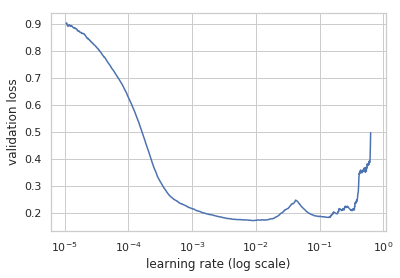

In [34]:
m = md.get_learner(**learner_params)
m.lr_find()
m.sched.plot()

In [35]:
lr = 1e-3
m = md.get_learner(**learner_params)
m.fit(lr, 5, cycle_len=3)

epoch      trn_loss   val_loss                                  
    0      0.152937   0.141299  
    1      0.14083    0.132066                                  
    2      0.136703   0.131287                                  
    3      0.127595   0.124635                                  
    4      0.123376   0.122147                                  
    5      0.121443   0.120934                                  
    6      0.120237   0.118555                                  
    7      0.115598   0.11745                                   
    8      0.115713   0.116751                                  
    9      0.116108   0.11543                                   
    10     0.111362   0.113665                                  
    11     0.111265   0.113152                                  
    12     0.112358   0.113743                                  
    13     0.110766   0.111194                                  
    14     0.110116   0.110768                           

[array([0.11077])]

In [36]:
save_model_ignoring(m, 'pretrain-noiser-trn110-val110', ['outp'])

In [37]:
m.fit(lr, 5, cycle_len=3)

epoch      trn_loss   val_loss                                  
    0      0.110522   0.110857  
    1      0.109255   0.109517                                  
    2      0.106685   0.108984                                  
    3      0.110769   0.108645                                  
    4      0.10638    0.106214                                  
    5      0.106696   0.1059                                    
    6      0.108417   0.105105                                  
    7      0.10504    0.103593                                  
    8      0.103651   0.103485                                  
    9      0.107834   0.103839                                  
    10     0.105036   0.101303                                  
    11     0.103566   0.10078                                   
    12     0.106061   0.101173                                  
    13     0.102702   0.099729                                  
    14     0.104161   0.098931                           

[array([0.09893])]

In [38]:
save_model_ignoring(m, 'pretrain-noiser-trn104-val098', ['outp'])

In [44]:
m.fit(lr, 5, cycle_len=3)

epoch      trn_loss   val_loss                                  
    0      0.104096   0.099369  
    1      0.101206   0.098714                                  
    2      0.103094   0.098372                                  
    3      0.104227   0.099072                                  
    4      0.102291   0.098447                                  
    5      0.100432   0.097468                                   
    6      0.103894   0.099841                                  
    7      0.101558   0.095832                                   
    8      0.101402   0.095505                                   
    9      0.103554   0.096985                                  
    10     0.10051    0.095654                                  
    11     0.100108   0.09522                                    
    12     0.103556   0.09798                                   
    13     0.100101   0.096617                                   
    14     0.098836   0.09562                       

[array([0.09562])]

In [45]:
m.fit(lr, 5, cycle_len=3)

epoch      trn_loss   val_loss                                  
    0      0.100797   0.095452  
    1      0.100405   0.095087                                   
    2      0.10038    0.094681                                   
    3      0.101882   0.096549                                  
    4      0.100692   0.094347                                   
    5      0.099186   0.094578                                   
    6      0.100422   0.096438                                  
    7      0.099682   0.093472                                   
    8      0.098521   0.093517                                   
    9      0.10168    0.095067                                  
    10     0.099769   0.093147                                   
    11     0.098224   0.093069                                   
    12     0.101416   0.096469                                  
    13     0.099613   0.094093                                   
    14     0.09857    0.093687                  

[array([0.09369])]

In [46]:
m.fit(lr, 5, cycle_len=3)

epoch      trn_loss   val_loss                                   
    0      0.099456   0.0972    
    1      0.099144   0.09463                                    
    2      0.098214   0.094339                                   
    3      0.099607   0.096069                                   
    4      0.100005   0.095559                                   
    5      0.099083   0.093893                                   
    6      0.100879   0.095656                                   
    7      0.099116   0.094495                                   
    8      0.09855    0.094173                                   
    9      0.100827   0.093531                                   
    10     0.096915   0.093907                                   
    11     0.097847   0.093799                                   
    12     0.10064    0.095935                                   
    13     0.099546   0.093957                                   
    14     0.098451   0.094007             

[array([0.09401])]

In [47]:
save_model_ignoring(m, 'pretrain-noiser-trn098-val094', ['outp'])

In [48]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": y.shape[1], # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)
lr = 1e-3
m.fit(lr, 10, cycle_len=3)

epoch      trn_loss   val_loss                                  
    0      0.131883   0.127716  
    1      0.119997   0.115065                                  
    2      0.117689   0.113245                                  
    3      0.110952   0.102252                                  
    4      0.105127   0.093933                                  
    5      0.102867   0.092113                                  
    6      0.102342   0.086646                                  
    7      0.097681   0.080707                                   
    8      0.096628   0.079894                                   
    9      0.097955   0.077204                                   
    10     0.092194   0.074514                                   
    11     0.092593   0.073925                                   
    12     0.093862   0.072649                                   
    13     0.090389   0.071606                                   
    14     0.090511   0.070823                    

[array([0.0646])]

In [49]:
m.save('completo-pretrain-noiser-trn083-val064')

In [51]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": y.shape[1], # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)
m.load('completo-pretrain-noiser-trn083-val064')
lr = 1e-3
m.fit(lr, 10, cycle_len=3)

epoch      trn_loss   val_loss                                   
    0      0.086628   0.065612  
    1      0.082622   0.064372                                   
    2      0.082312   0.063973                                   
    3      0.085824   0.066068                                   
    4      0.083122   0.064447                                   
    5      0.079924   0.063903                                   
    6      0.084487   0.065674                                   
    7      0.08125    0.063205                                   
    8      0.080169   0.063016                                   
    9      0.08269    0.064303                                   
    10     0.083052   0.061993                                   
    11     0.08036    0.062281                                   
    12     0.082403   0.064831                                   
    13     0.080824   0.064574                                   
    14     0.081129   0.064379             

[array([0.06554])]

In [52]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": y.shape[1], # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.load('completo-pretrain-noiser-trn083-val064')
save_model_ignoring(m, 'pretrain-noiser-trn083-val064', ['outp'])